In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from BufferStockModel import ConSavModelClass
from FEmodel import FEModelClass


# Set the number of threads in numba
# nb.set_num_threads(4)

This notebook serves to illustrate first the implications of a standard buffer-stock model. Afterwards, the results for an extended model with individual fixed effects and heterogeneous income profiles are.

## Standard Buffer-Stock

Solve and simulate

In [2]:
model = ConSavModelClass()

In [3]:
model.solve(algo='egm', do_print = False)

In [4]:
model.prepare_simulate(algo='hist')
model.simulate_hist_alt()

model prepared for simulation in 0.0 secs
model simulated in 2.4 secs [256 iterations]


Plot the results

In [5]:
par = model.par
sol = model.sol
sim = model.sim

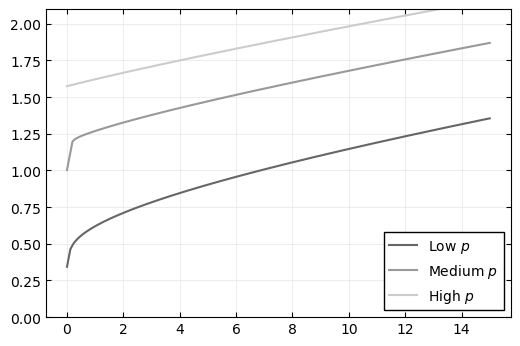

In [6]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)


ax.plot(par.a_grid,sol.c[0,:], color = '0.4', label = 'Low $p$',zorder=2)
ax.plot(par.a_grid,sol.c[3,:], color = '0.6', label = 'Medium $p$',zorder=2)
ax.plot(par.a_grid,sol.c[-1,:], color = '0.8', label = 'High $p$',zorder=2)


ax.set_ylim(0,2.1)
# ax.set_xlim(0,5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.show()


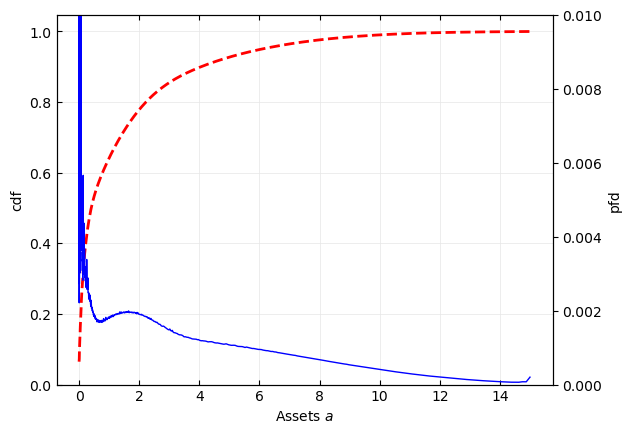

In [17]:
# Distribution matrix (two-dimensional)
D = sim.D_

# Compute density by weighted sum of each row
pdf = np.sum(D,axis=(0,))

# Compute CDF as the cumulative sum over the pdf
cdf = np.cumsum(pdf)

# Run figure
fig, ax1 = plt.subplots()

ax1.plot(par.a_grid, cdf, ls='--', c = 'red', lw=2, label='CDF, left axis',zorder=2)
ax1.set_xlabel('Assets $a$')
ax1.set_ylabel('cdf')

ax1.set_ylim(0) 
ax1.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax1.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')


ax2 = ax1.twinx()
ax2.set_ylim(0,0.01) 

ax2.plot(par.a_grid, pdf, ls='-', c = 'blue', lw=1, label='PDF, right axis',zorder=1)
ax2.set_xlabel('Assets $a$')
ax2.set_ylabel('pfd')


# ax1.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, loc = 4)

plt.show()

## FE model

To add in the model
- Finite lifetime
- Individual $\beta$'s
- Individual innate ability
- Individual choice of level and shape

In [30]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from BufferStockModel import ConSavModelClass
from FEmodel import FEModelClass


# Set the number of threads in numba
# nb.set_num_threads(4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
modelfe = FEModelClass()

In [202]:
modelfe.solve()

model solved in 4.8 secs


In [192]:
sol = modelfe.sol
par = modelfe.par

In [206]:
sol.alpha_l

array([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]])

Check how the policy functions look

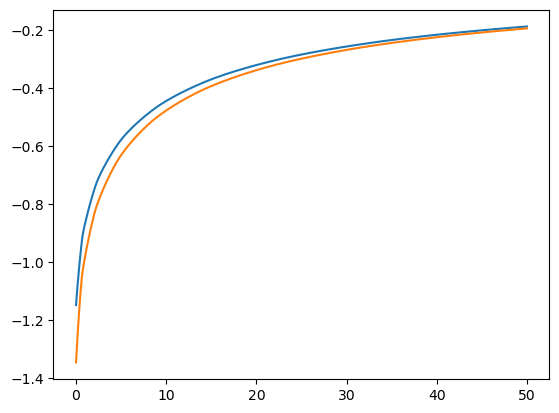

In [50]:
plt.plot(par.a_grid,sol.v[0,1,1,1,3,:])
plt.plot(par.a_grid,sol.v[0,1,1,1,2,:])

In [140]:
expectation_exante = np.zeros((par.Nbeta,par.Nalpha_l,par.Nalpha_s))

# betas are assumed known before choice, so loop over them
for i_beta in range(par.Nbeta):

    # compute beginning of period expectation, using the ergodic distribution of productivity
    for i_z in range(par.Nz):

        # probability weight
        w = par.z_ergodic[i_z]

        # expected value, assuming life starts with zero assets
        expectation_exante[i_beta,:,:] += w*sol.v[0,i_beta,:,:,i_z,0]


In [98]:
expectation_exante[-1]

array([[-6.03994131, -5.04093833],
       [-5.6220886 , -4.73948459]])

In [110]:
# weights of penalty terms
w_l = 2.0
w_s = 1.0

# loop over values of innate ability
val_of_choice = np.zeros((par.Nbeta,par.Nalpha_l,par.Nalpha_s)) # initialize
for i_beta in range(par.Nbeta):
    for i_alpha_tilde in [9]:
        for i_alpha_l in range(par.Nalpha_l):
            for i_alpha_s in range(par.Nalpha_s):

                # unpack states
                alpha_l = par.alpha_l_grid[i_alpha_l]
                alpha_s = par.alpha_s_grid[i_alpha_s]
                alpha_tilde = par.alpha_tilde_grid[i_alpha_tilde]

                # penalty term
                penalty = -1*(w_l*(alpha_l - alpha_tilde)**2 + w_s*(alpha_s - alpha_tilde))**2

                # value of choice of (alpha_l,alpha_s)
                val_of_choice[i_beta,i_alpha_l,i_alpha_s] = expectation_exante[i_beta,i_alpha_l,i_alpha_s] + penalty

In [111]:
val_of_choice

array([[[-2.11258063, -1.86974793],
        [-2.1462872 , -1.89843513]],

       [[-2.43147168, -2.14208916],
        [-2.43867805, -2.15089063]],

       [[-2.97207384, -2.58956669],
        [-2.93737307, -2.56872022]],

       [[-4.06967535, -3.47259356],
        [-3.96013292, -3.40259059]],

       [[-6.88634131, -5.71333833],
        [-6.6220886 , -5.54948459]]])

In [129]:
val_of_choice[0,:,:]

array([[-2.11258063, -1.86974793],
       [-2.1462872 , -1.89843513]])

In [ ]:
np.unravel_index()

In [134]:
x = np.unravel_index(np.argmax(val_of_choice[0,:,:],axis=None),val_of_choice[0,:,:].shape)
print(x)

(0, 1)


In [72]:
print(par.alpha_tilde_grid)

[0.9        0.92222222 0.94444444 0.96666667 0.98888889 1.01111111
 1.03333333 1.05555556 1.07777778 1.1       ]


In [37]:
plt.plot(par.a_grid,sol.c[0,0,2,:], color = '0.0') # Low beta
plt.plot(par.a_grid,sol.c[0,1,2,:], color = '0.2')
plt.plot(par.a_grid,sol.c[0,2,2,:], color = '0.4')
plt.plot(par.a_grid,sol.c[0,3,2,:], color = '0.6')
plt.plot(par.a_grid,sol.c[0,4,2,:], color = '0.8') # High beta

plt.show()

IndexError: index 2 is out of bounds for axis 2 with size 2

In [26]:
sol.c.shape

(20, 5, 5, 500)

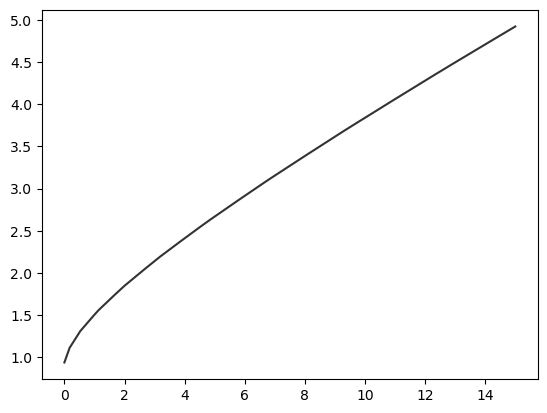

In [25]:
plt.plot(par.a_grid,sol.c[0,1,2,:], color = '0.2')

In [74]:
H = 20
for h in reversed(range(H)):
    print(h)

19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [27]:
modelfe.par.z_ergodic

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])